In [ ]:
# Andrej Baranovskij, Katana ML: https://katanaml.io/, https://github.com/katanaml
# TensorFlow Decision Forests (currently runs only on Linux OS): https://www.tensorflow.org/decision_forests
# Titanic dataset from: https://www.kaggle.com/c/titanic

!pip install tensorflow_decision_forests


     |████████████████████████████████| 6.2MB 3.5MB/s 


In [ ]:
!pip install wurlitzer

In [ ]:
import tensorflow_decision_forests as tfdf

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

In [ ]:
#@title The hidden code cell limits the output height in colab.

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [ ]:
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v0.1.7


In [ ]:
train_df = pd.read_csv("https://raw.githubusercontent.com/katanaml/sample-apps/master/12/tf-decision-forests/data/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/katanaml/sample-apps/master/12/tf-decision-forests/data/test.csv")

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train_df = train_df.drop(['PassengerId'], axis=1)
test_df = test_df.drop(['PassengerId'], axis=1)

In [ ]:
# Extract deck info from cabin

deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset.loc[dataset['Deck']==8,['Deck']] = np.nan

train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [ ]:
# Extract title info from name

data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)

train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [ ]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [ ]:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title
0,0,3,male,22.0,1,0,7.2500,S,NaN,1
1,1,1,female,38.0,1,0,71.2833,C,3.0,3
2,1,3,female,26.0,0,0,7.9250,S,NaN,2
3,1,1,female,35.0,1,0,53.1000,S,3.0,3
4,0,3,male,35.0,0,0,8.0500,S,NaN,1
5,0,3,male,NaN,0,0,8.4583,Q,NaN,1
6,0,1,male,54.0,0,0,51.8625,S,5.0,1
7,0,3,male,2.0,3,1,21.0750,S,NaN,4
8,1,3,female,27.0,0,2,11.1333,S,NaN,3
9,1,2,female,14.0,1,0,30.0708,C,NaN,3


In [ ]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="Survived")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

In [ ]:
%set_cell_height 300

# Specify the model.
model = tfdf.keras.RandomForestModel()
# model = tfdf.keras.GradientBoostedTreesModel()

# Optionally, add evaluation metrics.
model.compile(metrics=["accuracy"])

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
  model.fit(x=train_ds)

<IPython.core.display.Javascript object>

14/14 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 14
[INFO kernel.cc:393] Number of examples: 891
[INFO kernel.cc:769] Dataset:
Number of records: 891
Number of columns: 10

Number of columns by type:
	NUMERICAL: 7 (70%)
	CATEGORICAL: 3 (30%)

Columns:

NUMERICAL: 7 (70%)
	0: "Age" NUMERICAL num-nas:177 (19.8653%) mean:29.6991 min:0.42 max:80 sd:14.5163
	1: "Deck" NUMERICAL num-nas:688 (77.2166%) mean:3.36946 min:1 max:7 sd:1.4406
	3: "Fare" NUMERICAL mean:32.2042 min:0 max:512.329 sd:49.6655
	4: "Parch" NUMERICAL mean:0.381594 min:0 max:6 sd:0.805605
	5: "Pclass" NUMERICAL mean:2.30864 min:1 max:3 sd:0.835602
	7: "SibSp" NUMERICAL mean:0.523008 min:0 max:8 sd:1.10212
	8: "Title" NUMERICAL mean:1.7284 min:1 max:5 sd:1.02946

CATEGORICAL: 3 (30%)
	2: "Embarked" CATEGORICAL num-nas:2 (0.224467%) has-dict vocab-size:4 zero-ood-items most-frequent:"S" 644 (72.4409%)
	6: "Sex" CATEGORICAL has-dict vocab

In [ ]:
%set_cell_height 300

predictions = model.predict(test_ds)
print(predictions)

<IPython.core.display.Javascript object>

[[0.04      ]
 [0.39666638]
 [0.05666667]
 [0.12999995]
 [0.5966662 ]
 [0.03      ]
 [0.6833328 ]
 [0.19999988]
 [0.8299993 ]
 [0.02      ]
 [0.        ]
 [0.07      ]
 [0.9899992 ]
 [0.01333333]
 [0.99666584]
 [0.9499992 ]
 [0.01      ]
 [0.25333318]
 [0.3999997 ]
 [0.68666613]
 [0.20666654]
 [0.5699996 ]
 [0.9733325 ]
 [0.2466665 ]
 [0.95333254]
 [0.        ]
 [0.99999917]
 [0.23999985]
 [0.5066663 ]
 [0.14999993]
 [0.05      ]
 [0.10666663]
 [0.5833329 ]
 [0.3666664 ]
 [0.39333305]
 [0.18666656]
 [0.08999998]
 [0.13666661]
 [0.03333334]
 [0.6266662 ]
 [0.06666667]
 [0.7399994 ]
 [0.08999998]
 [0.97666585]
 [0.9899992 ]
 [0.05666667]
 [0.3333331 ]
 [0.00333333]
 [0.99666584]
 [0.6933328 ]
 [0.2766665 ]
 [0.14333327]
 [0.7499994 ]
 [0.78999937]
 [0.11666662]
 [0.02      ]
 [0.00666667]
 [0.09999997]
 [0.        ]
 [0.99999917]
 [0.03333334]
 [0.09333331]
 [0.        ]
 [0.8599993 ]
 [0.6933328 ]
 [0.95333254]
 [0.816666  ]
 [0.03666667]
 [0.2666665 ]
 [0.8399993 ]
 [0.81999934]
 [0.  

In [ ]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title
0,3,male,34.5,0,0,7.8292,Q,NaN,1
1,3,female,47.0,1,0,7.0000,S,NaN,3
2,2,male,62.0,0,0,9.6875,Q,NaN,1
3,3,male,27.0,0,0,8.6625,S,NaN,1
4,3,female,22.0,1,1,12.2875,S,NaN,3


In [ ]:
model.save("/tmp/my_saved_model")

INFO:tensorflow:Assets written to: /tmp/my_saved_model/assets


INFO:tensorflow:Assets written to: /tmp/my_saved_model/assets


In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

In [ ]:
%set_cell_height 300
model.summary()

<IPython.core.display.Javascript object>

Model: "random_forest_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (9):
	Age
	Deck
	Embarked
	Fare
	Parch
	Pclass
	Sex
	SibSp
	Title

No weights

Variable Importance: NUM_NODES:
    1.     "Fare" 9178.000000 ################
    2.      "Age" 8430.000000 ##############
    3.    "SibSp" 1297.000000 #
    4. "Embarked" 1258.000000 #
    5.   "Pclass" 1134.000000 #
    6.     "Deck" 1088.000000 #
    7.    "Parch" 889.000000 
    8.    "Title" 721.000000 
    9.      "Sex" 442.000000 

Variable Importance: NUM_AS_ROOT:
    1.      "Sex" 113.000000 ################
    2.    "Title" 95.000000 #############
    3.     "Fare" 47.000000 ######
    4.   "Pclass" 28.000000 ###
    5. "Embarked"  6.000

In [ ]:
# The input features
model.make_inspector().features()

["Age" (1; #0),
 "Deck" (1; #1),
 "Embarked" (4; #2),
 "Fare" (1; #3),
 "Parch" (1; #4),
 "Pclass" (1; #5),
 "Sex" (4; #6),
 "SibSp" (1; #7),
 "Title" (1; #8)]

In [ ]:
# The feature importances
model.make_inspector().variable_importances()

{'NUM_AS_ROOT': [("Sex" (4; #6), 113.0),
  ("Title" (1; #8), 95.0),
  ("Fare" (1; #3), 47.0),
  ("Pclass" (1; #5), 28.0),
  ("Embarked" (4; #2), 6.0),
  ("Deck" (1; #1), 5.0),
  ("Age" (1; #0), 3.0),
  ("Parch" (1; #4), 2.0),
  ("SibSp" (1; #7), 1.0)]}

In [ ]:
model.make_inspector().evaluation()

Evaluation(num_examples=891, accuracy=0.8395061728395061, loss=0.7994232416470711, rmse=None, ndcg=None, aucs=None)

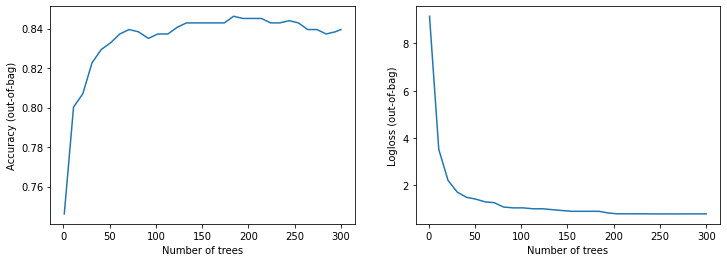

In [ ]:
logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()